# Estimating entanglement in teleportation experiments
## Paul Skrzypczyk, Matty Hoban, Belen Sainz and Noah Linden
### Jupyter notebook to accompany [arXiv:1908.xxxxx](https://arxiv.org/abs/1908.xxxxx)

#### Introduction

In this notebook we reproduce the numerical findings from the above paper. 

To run this notebook you will need:

- Matlab with the [API for Python](https://www.mathworks.com/help/matlab/matlab-engine-for-python.html) installed.
- The [Calysto Matlab kernel for Python](https://github.com/Calysto/matlab_kernel) 
- [CVX](http://cvxr.com/) Software for Disciplined Convex Programming 
- [QETlab](http://www.qetlab.com/Main_Page) a MATLAB toolbook for quantum entanglement.
- The codes provided in this the github repository

### Example with d = 3, m = 3, o = 2

Preliminaries

In [155]:
o = 2; % number of outcomes
m = 3; % number of measurements
d = 3; % dimension of Hilbert space
nd = o^m; % number of outcomes of maximal parent

SingleParty = genSinglePartyArray(o,m); % generate deterministic strategies
SingleParty = squeeze(SingleParty(1,:,:)); % only need first element because 2 outcome

Define the measurements

In [157]:
theta = pi/8;

ct = cos(theta);
st = sin(theta);

X = Pauli(1);
Z = Pauli(3);

X01 = zeros(3,3); X01(1:2,1:2) = X;
X02 = zeros(3,3); X02([1,3],[1,3]) = X;
X12 = zeros(3,3); X12(2:3,2:3) = X;

Z01 = zeros(3,3); Z01(1:2,1:2) = Z;
Z02 = zeros(3,3); Z02([1,3],[1,3]) = Z;
Z12 = zeros(3,3); Z12(2:3,2:3) = Z;

I3 = eye(3);

Max = zeros(3,3,3);

Max(:,:,1) = 1/2*(I3 + 3*sqrt(2)/8*X01 + 1/2*X02);
Max(:,:,2) = 1/2*(I3 + 3*sqrt(2)/8*Z01 + 1/2*X12);
Max(:,:,3) = 1/2*(I3 + 1/2*Z02 + 1/2*Z12);

Analytic form for (maximal) parent:

In [158]:
Ga = zeros(3,3,8);

Ga(1:2,1:2,1) = 3/8*[ct;st]*[ct,st];
Ga(1:2,1:2,3) = 3/8*[st;ct]*[st,ct];
Ga(1:2,1:2,5) = 3/8*[-ct;st]*[-ct,st];
Ga(1:2,1:2,7) = 3/8*[-st;ct]*[-st,ct];

Ga(:,:,2) = 3/8*[1/sqrt(6);1/sqrt(6);sqrt(2/3)]*[1/sqrt(6),1/sqrt(6),sqrt(2/3)];
Ga(:,:,4) = 3/8*[1/sqrt(6);-1/sqrt(6);sqrt(2/3)]*[1/sqrt(6),-1/sqrt(6),sqrt(2/3)];
Ga(:,:,6) = 3/8*[1/sqrt(6);-1/sqrt(6);-sqrt(2/3)]*[1/sqrt(6),-1/sqrt(6),-sqrt(2/3)];
Ga(:,:,8) = 3/8*[1/sqrt(6);1/sqrt(6);-sqrt(2/3)]*[1/sqrt(6),1/sqrt(6),-sqrt(2/3)];

Check that this is a valid normalised measurement (POVM elements are positive-semidefinite by construction)

In [159]:
sum(Ga,3)

ans =
    1.0000    0.0000         0
    0.0000    1.0000         0
         0         0    1.0000


Check that the parent faithfully reproduces the measurements:

In [160]:
[sumall(abs(Max(:,:,1) - sum(Ga(:,:,[1,2,3,4]),3))) ...
sumall(abs(Max(:,:,2) - sum(Ga(:,:,[1,2,5,6]),3))) ...
sumall(abs(Max(:,:,3) - sum(Ga(:,:,[1,3,5,7]),3)))]

ans =
   1.0e-15 *
    0.1110    0.2498    0.1110


Check via the SDP that the measurements are jointly measurable.  
This is a consistency check, since we already know this is the case.

In [161]:
cvx_begin sdp quiet

    variable nu 
    
    variable Glam(d,d,nd) hermitian
    % Glam is the parent POVM
    
    maximise nu

    Max == squeeze(sum(permute(repmat(SingleParty,[1,1,d,d]),[3,4,1,2]).*...
    permute(repmat(Glam,[1,1,1,m]),[1,2,4,3]),4));

    sum(Glam,3) == eye(d);
    % sum_lndambda G_lambda == 1
    
    for j = 1:nd
        Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
    end
           
    nu <= 0
    
cvx_end

cvx_optval

cvx_optval =
  -5.8370e-09


Check that the measurements cannot be reproduced by a parent with 7 outcomes or less:

In [162]:
results = NaN*zeros(1,nd);
V = zeros(d,d,m+1,8);
D = zeros(d,d,m+1,8);

for i = 1:8
    cvx_begin sdp quiet

        variable Glam(d,d,nd) hermitian
        variable nu 
        
        dual variables rho
        dual variable omega

        maximise nu
        
        rho : Max == squeeze(sum(permute(repmat(SingleParty,[1,1,d,d]),[3,4,1,2]).*...
        permute(repmat(Glam,[1,1,1,m]),[1,2,4,3]),4));

        omega : eye(d) == sum(Glam,3)
        % sum_lambda G_lambda == 1
        
        Glam(:,:,i) == zeros(d)
        
        for j = 1:nd
            Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
        end
        
        nu <= 0
        
    cvx_end
    
    for x = 1:m
        [V(:,:,x,i),D(:,:,x,i)] = eig(rho(:,:,x));
    end
    [V(:,:,m+1,i),D(:,:,m+1,i)] = eig(omega);
    
    results(1,i) = cvx_optval;
end

results

results =
  Columns 1 through 7
   -0.0429   -0.0399   -0.0298   -0.0266   -0.0429   -0.0399   -0.0298
  Column 8
   -0.0266


Ansatz dual solution giving analytic proof of the above numerical result:

In [163]:
alpha = [1,sqrt(2)/4];
beta = [0,sqrt(2)/4];
gam = [0,sqrt(3)/2];

Id = eye(3);

bound = zeros(1,8);
bounda = zeros(1,8);

for a0 = 0:1
    for a1 = 0:1
        for a2 = 0:1
            av = [a0 a1 a2];
            psi = alpha(a2+1)*(-1)^(a0+a1)*Id(:,a1+1) + beta(a2+1)*Id(:,~a1+1) + gam(a2+1)*(-1)^(a0*a1)*Id(:,3);
            omegalam(:,:,1+a2+2*a1+4*a0) = (~a2*(~a0+~a1)+a2*(~a0+~a1-1))/5*psi*psi';
            bound(1,1+a2+2*a1+4*a0) = trace(omegalam(:,:,1+a2+2*a1+4*a0));
            for x = 0:2
                rhoxlam(:,:,x+1,1+a2+2*a1+4*a0) = -1/5*(-1)^av(x+1)*psi*psi';
                bound(1,1+a2+2*a1+4*a0) = bound(1,1+a2+2*a1+4*a0) + trace(rhoxlam(:,:,x+1,1+a2+2*a1+4*a0)*Max(:,:,x+1));
            end
            if a2 == 0
                bounda(1,1+a2++2*a1+4*a0) = 1/8-3/20*ct^2;
            elseif a2 == 1
                bounda(1,1+a2++2*a1+4*a0) = 3/80 - sqrt(6)/40 - (-1)^a1*3/80*ct*st;
            end
        end
    end
end

[bound; bounda]

ans =
  Columns 1 through 7
   -0.0030   -0.0370   -0.0030   -0.0105   -0.0030   -0.0370   -0.0030
   -0.0030   -0.0370   -0.0030   -0.0105   -0.0030   -0.0370   -0.0030
  Column 8
   -0.0105
   -0.0105


Check numerically that these are indeed valid solutions to the dual SDP:

In [164]:
mineig = NaN*zeros(8,8);
tracecond = zeros(1,8);
for i = 1:8
    for j = [1:i-1, i+1:8]
        mineig(i,j) = eigs(omegalam(:,:,i) + sum(permute(repmat(SingleParty(:,j),...
            [1,d,d]),[2,3,1]).*rhoxlam(:,:,:,i),3),1,'smallestreal');
    end
    tracecond(1,i) = trace(sum(sum(permute(repmat(SingleParty(:,[1:i-1, i+1:8]),...
        [1,1,d,d]),[3,4,1,2]).*rhoxlam(:,:,:,[1:i-1, i+1:8]),4),3)) + 7*trace(omegalam(:,:,i));
end
mineig
tracecond

mineig =
   1.0e-16 *
  Columns 1 through 4
      NaN + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i
   0.0000 + 0.0000i      NaN + 0.0000i  -0.0289 + 0.0000i   0.0000 + 0.0000i
   0.0000 + 0.0000i   0.0000 + 0.0000i      NaN + 0.0000i   0.0000 + 0.0000i
  -0.0289 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i      NaN + 0.0000i
   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i
  -0.0289 + 0.0000i   0.0000 + 0.0000i  -0.5551 + 0.0000i  -0.0289 + 0.0000i
   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i
  -0.1665 + 0.0249i  -0.0289 + 0.0000i  -0.0289 + 0.0000i   0.0000 + 0.0000i
  Columns 5 through 8
   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i
  -0.0289 + 0.0000i   0.0000 + 0.0000i  -0.5551 + 0.0000i  -0.0289 + 0.0000i
   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i   0.0000 + 0.0000i
  -0.5551 + 0.0000i  -0.0289 + 0.0000i  -0.0289 + 0.0000i   0.0000 + 0.0000i
      NaN 

### Attempt to sample from the space of measurements

Basic idea: 
- Pick a set of random unitary matrices (from Haar), and use this to define a set of projective measurements
- Calculate the robustness of this set of measurements, and extract the dual variables
- Maximise the linear functional obtained from the dual variables over the set of compatible measurements

This will generate a set of compatible measurements on the boundary of the set. We can then check the complexity of these boundary sets of measurements

In [263]:
%%file sampleCompatibleBoundary.m

function C = sampleCompatibleBoundary(d,m)

o = d;
nd = o^m; % number of outcomes of maximal parent
eps = 1e-6; % tolerance for having found a parent
flag = 0;

Max = genRandProjMeas(d,m);
Max = Max(:,:,1:o-1,:);

SingleParty = genSinglePartyArray(o,m); % generate deterministic strategies
SingleParty = SingleParty(1:o-1,:,:); % don't need last outcome

% 1. obtain dual variables

cvx_begin sdp quiet

    variable nu 
    variable Glam(d,d,nd) hermitian

    dual variable rhoax
    dual variable omega

    maximise nu

    rhoax : Max == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
    permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

    omega : eye(d) == sum(Glam,3);

    for j = 1:nd
        Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
    end

    nu <= 0

cvx_end

% 2. Find compatible measurements minimising linear functional

cvx_begin quiet

    variable Glam(d,d,nd) hermitian semidefinite
    expression Nax(d,d,o-1,m)

    Nax = sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
    permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

    minimise real(sumall(conj(rhoax).*Nax(:,:,1:o-1,:))) + trace(omega)

    sum(Glam,3) == eye(d)

cvx_end

% 3. check for simpler parent

results = NaN*zeros(1,nd);

for i = 1:nd

    cvx_begin sdp quiet

        variable nu 
        variable Glam(d,d,nd) hermitian

        maximise nu

        Nax == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
            permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

        eye(d) == sum(Glam,3);

        for j = 1:nd
            Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
        end

        nu <= 0

        Glam(:,:,i) == zeros(d)

    cvx_end

    results(1,i) = cvx_optval;
end

% now the complicated bit: try and search (smartly) for the number of elements needed

list1 = find(results >= -eps); % generate primary list
n1 = length(list1); % find its size
listp = list1'; %the initial 'previous list' will be list1
    
for j = 2:n1 % need to consider subets of size 2 and above
    [np,~] = size(listp); % size of the previous list of subsets
    combs = nchoosek(list1,j); % these are _all_ the possible combinations compatible with the singletons
    [nc,~] = size(combs); % number of combinations
    resultsj = [];
    for k = 1:nc
        subs = nchoosek(combs(k,:),j-1); % create al the subsets of size k-1 of the list of combinations of size k
        [ns,~] = size(subs); % number of subsets to check
        issubsetv = zeros(1,ns); % vector to store the comparison
        for l = 1:ns
            for n = 1:np
                issubsetv(1,l) = issubsetv(1,l) + double(isequal(subs(l,:),listp(n,:)));
                % check whether the subset l is contained in the previous list
            end
        end

        if prod(issubsetv) == 1 % then this is a valid choice

            cvx_begin sdp quiet

                variable nu 
                variable Glam(d,d,nd) hermitian

                maximise nu

                Nax == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
                    permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

                eye(d) == sum(Glam,3);

                for lam = 1:nd
                    Glam(:,:,lam) - nu*eye(d) == hermitian_semidefinite(d)
                end

                nu <= 0

                for l = 1:j % these are the elements that now need to vanish
                    Glam(:,:,combs(k,l)) == zeros(d)
                end

            cvx_end

            resultsj = [resultsj cvx_optval]; % add the result
            
        end  
    end
        
    listj = find(resultsj >= -eps); % find out which combinations give a valid parent

    if length(listj) == 0 % if none work
        C = nd - j + 1; % must have only been possible to find a parent at the level above
        flag = 1; % flag to say that we are done
        break % break out of the loop - we're finished
    end
        
    listp = combs(listj,:); % if we didn't break out of the loop, then we need to set listp to be the new list found
        
end

% if we never broke out above, then it was possible to set everybody in list1 to vanish

if flag == 0
    C = nd - n1;
end

Created file '/home/phyps/Dropbox/MATLAB/Noah/sampleCompatibleBoundary.m'.


### (d = 3, m = 2) data collection

Elapsed time is 1888.340974 seconds.


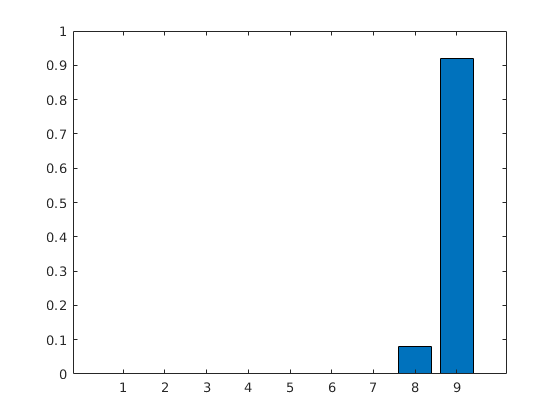

In [320]:
clear
tic

d = 3; % dimension of Hilbert space
m = 2; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 4, m = 2) data collection

Elapsed time is 4219.692281 seconds.


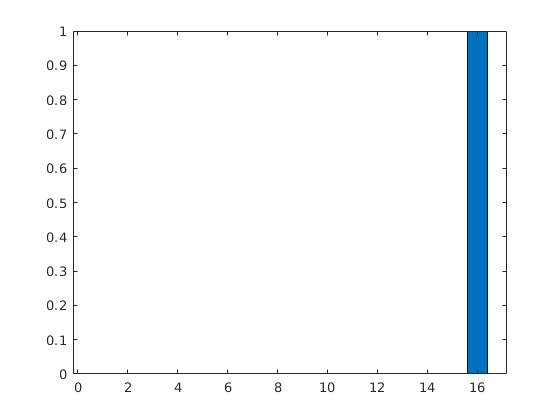

In [321]:
clear
tic

d = 4; % dimension of Hilbert space
m = 2; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 5, m = 2) data collection

Elapsed time is 9202.887044 seconds.


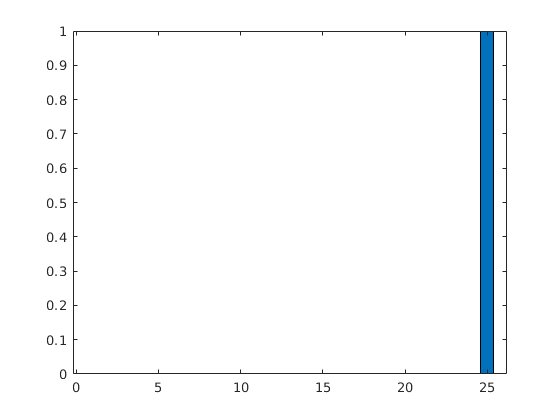

In [322]:
clear
tic

d = 5; % dimension of Hilbert space
m = 2; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 2,m = 3) data collection

Elapsed time is 1809.134337 seconds.


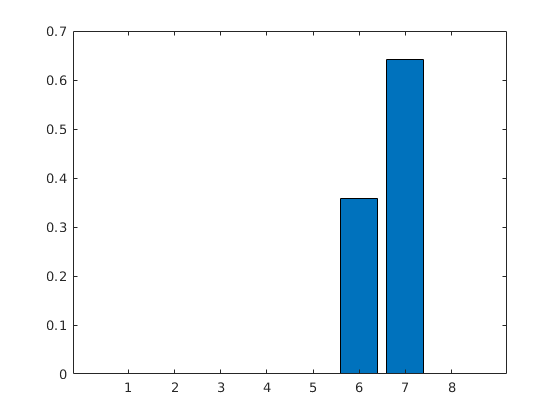

In [323]:
clear
tic

d = 2; % dimension of Hilbert space
m = 3; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 3,m = 3) data collection

Elapsed time is 179899.836701 seconds.


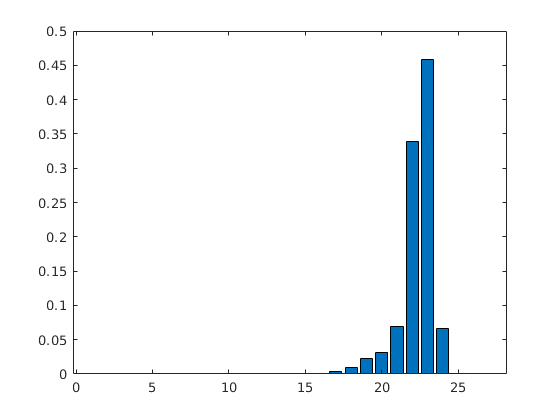

In [324]:
clear
tic

d = 3; % dimension of Hilbert space
m = 3; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 2,m = 4) data collection

Elapsed time is 38062.394908 seconds.


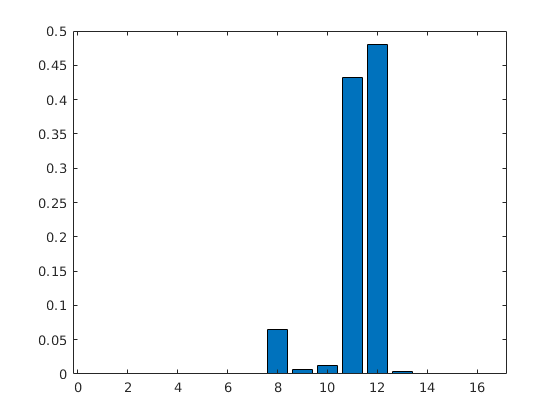

In [325]:
clear
tic

d = 2; % dimension of Hilbert space
m = 4; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### (d = 2,m = 5) data collection

In [ ]:
clear
tic

d = 2; % dimension of Hilbert space
m = 5; % number of measurements

nrun = 1000;
data = zeros(1,d^m);

for run = 1:nrun;

    C = sampleCompatibleBoundary(d,m);
    data(1,C) = data(1,C) + 1;
    
end

%bar(data/nrun)

toc

dataname = strcat(pwd,'/data/sampleCompBound_data_',num2str(d),'_',num2str(m),'.mat');

if exist(dataname) == 2
    datanew = data;
    load(dataname);
    data = data + datanew;
    save(dataname,'data');
else
    save(dataname,'data');
end

bar(data/sum(data))

### Code to check whether a set of measurements is maximally complex

In [273]:
%%file searchMaximallyComplexCompatible.m

function [C,list,result,result_consist] = searchMaximallyComplexCompatible(d,m)

o = d;
nd = o^m; % number of outcomes of maximal parent
eps = 1e-7; % tolerance for having found a parent
flag = 0;

Max = genRandProjMeas(d,m);
Max = Max(:,:,1:o-1,:);

SingleParty = genSinglePartyArray(o,m); % generate deterministic strategies
SingleParty = SingleParty(1:o-1,:,:); % don't need last outcome

% 1. obtain dual variables

cvx_begin sdp quiet

    variable nu 
    variable Glam(d,d,nd) hermitian

    dual variable rhoax
    dual variable omega

    maximise nu

    rhoax : Max == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
    permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

    omega : eye(d) == sum(Glam,3);

    for j = 1:nd
        Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
    end

    nu <= 0

cvx_end

% 2. Find compatible measurements minimising linear functional

cvx_begin quiet

    variable Glam(d,d,nd) hermitian semidefinite
    expression Nax(d,d,o-1,m)

    Nax = sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
    permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

    minimise real(sumall(conj(rhoax).*Nax(:,:,1:o-1,:))) + trace(omega)

    sum(Glam,3) == eye(d)

cvx_end

% check the eigenvalue of the found parent:


cvx_begin sdp quiet

    variable nu 
    variable Glam(d,d,nd) hermitian

    maximise nu

    Nax == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
        permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

    eye(d) == sum(Glam,3);

    for j = 1:nd
        Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
    end

    nu <= 0

cvx_end

result_consist = cvx_optval;

% 3. check for simpler parent

results = NaN*zeros(1,nd);

for i = 1:nd

    cvx_begin sdp quiet

        variable nu 
        variable Glam(d,d,nd) hermitian

        maximise nu

        Nax == sum(permute(repmat(SingleParty,[1,1,1,d,d]),[4,5,1,2,3]).*...
            permute(repmat(Glam,[1,1,1,o-1,m]),[1,2,4,5,3]),5);

        eye(d) == sum(Glam,3);

        for j = 1:nd
            Glam(:,:,j) - nu*eye(d) == hermitian_semidefinite(d)
        end

        nu <= 0

        Glam(:,:,i) == zeros(d)

    cvx_end

    results(1,i) = cvx_optval;
end

% now the complicated bit: try and search (smartly) for the number of elements needed

list = find(results >= -eps); % generate primary list
n1 = length(list); % find its size

if n1 == 0
    C = true;
else
    C = false;
end

result = max(results);

end
    

Created file '/home/phyps/Dropbox/MATLAB/Noah/searchMaximallyComplexCompatible.m'.


Now let's use this to test for different situations:

In [239]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(3,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
   -0.0362
result_consist =
  -2.0506e-09


In [242]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(4,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
   -0.0096
result_consist =
  -3.3003e-08


In [249]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(5,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -4.4203e-04
result_consist =
  -1.7995e-08


In [250]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(6,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -5.6217e-04
result_consist =
  -1.8224e-08


In [274]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(7,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -1.3248e-04
result_consist =
  -6.3308e-08


In [270]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(8,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -1.0024e-06
result_consist =
  -5.5555e-08


In [271]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(9,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -3.2350e-06
result_consist =
  -3.2380e-08


In [272]:
[C,list,result,result_consist] = searchMaximallyComplexCompatible(10,2)

C =
  logical
   1
list =
  1x0 empty double row vector
result =
  -4.5180e-06
result_consist =
  -1.9607e-08
